Referencia: https://keras.io/examples/vision/image_classification_from_scratch/

Referencia: https://www.tensorflow.org/tutorials/images/classification

In [3]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model 
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D, BatchNormalization


## Data Processing

In [2]:
for dirname, _, filenames in os.walk('Cocoa_Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

Cocoa_Dataset\inmature\I1.jpg
Cocoa_Dataset\mature\M1.jpg


In [54]:
data_dir = os.path.join("Cocoa_Dataset")
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            validation_split=0.2,
                                                            shuffle=True,
                                                            subset="training",
                                                            seed=42,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=42,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)      
                                           

Found 476 files belonging to 2 classes.
Using 381 files for training.
Found 476 files belonging to 2 classes.
Using 95 files for validation.


['inmature', 'mature']


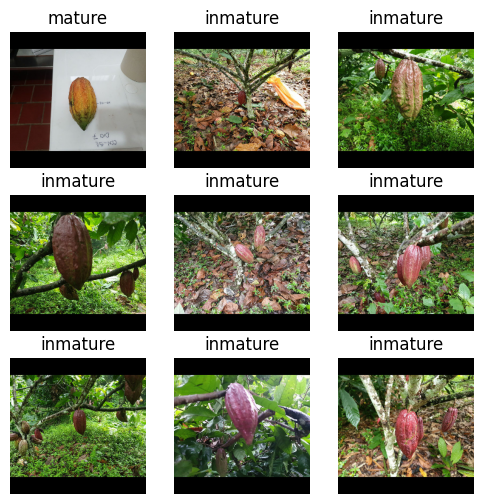

In [55]:
# Classes are inmature (0), mature (1)
class_names = train_ds.class_names
print(class_names)
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1): # takes one batch of images, let's see the first 9
    #print(images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data Augmentation

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [56]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(.5, .2),
    ]
)

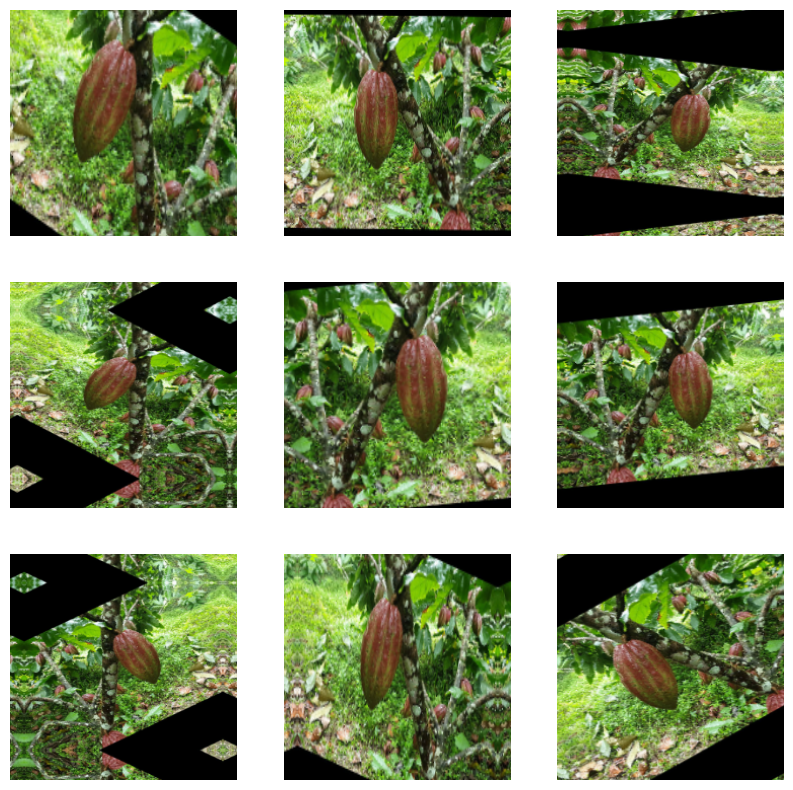

In [57]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Standardizing the data
Our image are already in a standard size (224x224), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer at the start of our model.

**Will be add to the model**

### Configure the dataset for performance
Let's apply data augmentation to our training dataset, and let's make sure to use buffered prefetching so we can yield data from disk without having I/O becoming blocking:

In [58]:
# GPUs are very fast for matrix computations, so we don't want the input/output of images to be a bottleneck.
# Prefetching with AUTOTUNE will help Tensorflow find the optimal way to load the images so that our GPU always has data to work on.
# More info: https://www.tensorflow.org/guide/data_performance#prefetching
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Build a model

In [59]:
model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(224, 224, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

In [60]:
epochs = 50
exp_name = "best_cnn_seq_v1" + ".keras"

callbacks = [
    keras.callbacks.ModelCheckpoint(exp_name, save_best_only=True),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
    verbose=0,
)

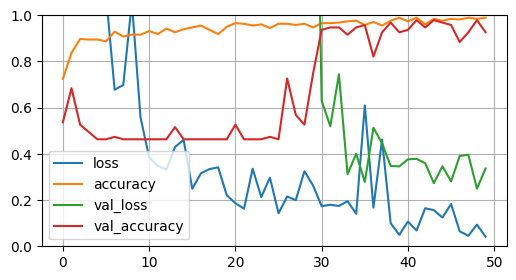

In [61]:
# se utiliza pandas para visualizar la información almacenada en el diccionario de historia de entrenamiento y graficarla. 
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(6, 3))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [64]:
model = load_model(exp_name)

In [65]:
scores_train = model.evaluate(train_ds)
scores_valid = model.evaluate(val_ds)

3/3 [==============================] - 0s 20ms/step - loss: 0.2495 - accuracy: 0.9789


In [66]:
print('train loss:', round(scores_train[0]*100,2), '%')
print('valid loss:', round(scores_valid[0]*100,2), '%')
print("\n")
print('train accuracy:', round(scores_train[1]*100,2), '%')
print('valid accuracy:', round(scores_valid[1]*100,2), '%')

train loss: 32.43 %
valid loss: 24.95 %


train accuracy: 95.28 %
valid accuracy: 97.89 %
